# Notebook for binary data preparation

In [325]:
import pandas as pd
import numpy as np

In [115]:
import os
def list_files_recursive(files, path='.'):
    for entry in os.listdir(path):
        full_path = os.path.join(path, entry)
        if os.path.isdir(full_path):
            list_files_recursive(files, full_path)
        else:
            files.append(full_path)

In [160]:
file_names = []
list_files_recursive(file_names, '../data/raw')

whole_df = pd.DataFrame()
for file_name in file_names:
    if file_name.endswith('.svc'):
        user = file_name.split('/')[-3]
        session = file_name.split('/')[-2]
        df = pd.read_csv(file_name,  delimiter=r"\s+", skiprows=[0], header=None)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'azimuth', 'altitude', 'pressure']
        df['user'] = user
        df['session'] = session
        df['collection'] = file_name.split('../data/raw/')[1].split('/')[0]
        
        whole_df = pd.concat([whole_df, df], axis=0)


In [280]:
labels_df['id'] = labels_df['Directory'] + labels_df['File Number user'].apply(lambda x: 'user' + str(x).rjust(5, '0'))

In [281]:
whole_df['id'] = whole_df['collection'] + whole_df['user']

In [282]:
whole_df.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,user,session,collection,id
0,47944,33492,671854,1,1800,490,67,user00001,session00001,Collection1,Collection1user00001
1,47949,33506,671861,1,1800,500,148,user00001,session00001,Collection1,Collection1user00001
2,47949,33512,671869,1,1800,500,193,user00001,session00001,Collection1,Collection1user00001
3,47950,33515,671876,1,1800,500,228,user00001,session00001,Collection1,Collection1user00001
4,47950,33519,671884,1,1800,500,270,user00001,session00001,Collection1,Collection1user00001


In [311]:
labels_df.head()
labels_df.rename(columns={'Suject': 'Subject'}, inplace=True)


In [312]:
labeled_data = pd.merge(whole_df, labels_df, how='inner', on='id')

In [313]:
labeled_data.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,user_x,session,collection,id,Subject,depression,anxiety,stress,Database Collectors,File Number user,Directory,user_y
0,47944,33492,671854,1,1800,490,67,user00001,session00001,Collection1,Collection1user00001,1,2,8,13,Passaniti; De Feo,1,Collection1,user00001
1,47949,33506,671861,1,1800,500,148,user00001,session00001,Collection1,Collection1user00001,1,2,8,13,Passaniti; De Feo,1,Collection1,user00001
2,47949,33512,671869,1,1800,500,193,user00001,session00001,Collection1,Collection1user00001,1,2,8,13,Passaniti; De Feo,1,Collection1,user00001
3,47950,33515,671876,1,1800,500,228,user00001,session00001,Collection1,Collection1user00001,1,2,8,13,Passaniti; De Feo,1,Collection1,user00001
4,47950,33519,671884,1,1800,500,270,user00001,session00001,Collection1,Collection1user00001,1,2,8,13,Passaniti; De Feo,1,Collection1,user00001


In [314]:
labeled_data.drop(['Directory', 'File Number user', 'user_x', 'session', 'collection', 'id', 'Database Collectors', 'Directory', 'user_y'], axis=1, inplace=True)

In [315]:
labeled_data.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,Subject,depression,anxiety,stress
0,47944,33492,671854,1,1800,490,67,1,2,8,13
1,47949,33506,671861,1,1800,500,148,1,2,8,13
2,47949,33512,671869,1,1800,500,193,1,2,8,13
3,47950,33515,671876,1,1800,500,228,1,2,8,13
4,47950,33519,671884,1,1800,500,270,1,2,8,13


In [316]:
labeled_data[labeled_data['Subject']==1]

,x,y,timestamp,pen_status,azimuth,altitude,pressure,Subject,depression,anxiety,stress
0,47944,33492,671854,1,1800,490,67,1,2,8,13
1,47949,33506,671861,1,1800,500,148,1,2,8,13
2,47949,33512,671869,1,1800,500,193,1,2,8,13
3,47950,33515,671876,1,1800,500,228,1,2,8,13
4,47950,33519,671884,1,1800,500,270,1,2,8,13
...,...,...,...,...,...,...,...,...,...,...,...
15957,6709,6953,875051,1,2210,690,852,1,2,8,13
15958,6712,6914,875058,1,2210,690,838,1,2,8,13
15959,6717,6872,875066,1,2190,700,793,1,2,8,13
15960,6719,6837,875073,1,2190,700,703,1,2,8,13


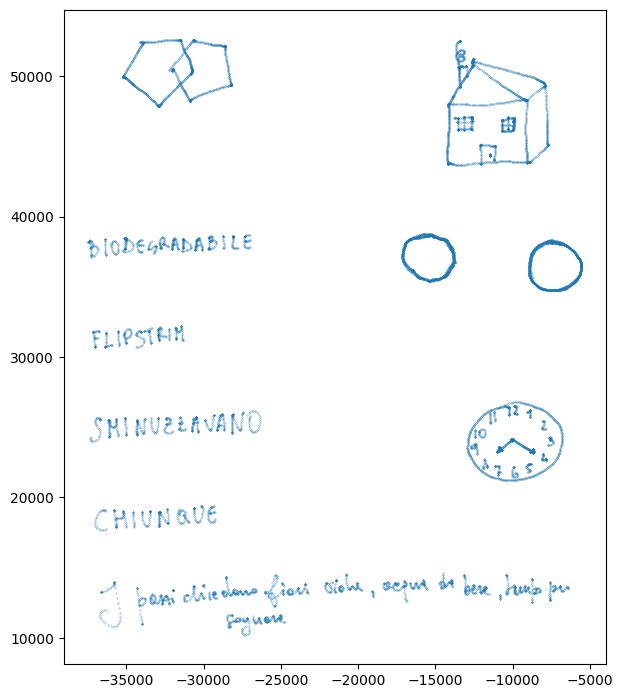

In [317]:
import matplotlib.pyplot as plt

sample_subject_data = labeled_data[(labeled_data['Subject']==129) & (labeled_data['pen_status']==1)]
plt.figure(figsize=(7,8.5))
plt.scatter(-sample_subject_data['y'], sample_subject_data['x'], s=0.05 )


In [318]:
labeled_data.to_parquet('../data/raw_binary/labeled_data.parquet')

# Data re-organization

In [368]:
whole_df = whole_df.sort_values(by=["id", "timestamp"])

# Group by subject and aggregate x-position and y-position as lists
data_as_array_df = whole_df.groupby(["id", "pen_status"]).agg({
    "x": list,
    "y": list,
    "timestamp": list,
    "azimuth": list,
    "altitude": list,
    "pressure": list
}).reset_index()

In [369]:
data_as_array_df.head()

,id,pen_status,x,y,timestamp,azimuth,altitude,pressure
0,Collection1user00001,0,"[48331, 48318, 48305, 48305, 48305, 48305, 483...","[31876, 31963, 32053, 32159, 32159, 32159, 321...","[672620, 672628, 672635, 672643, 672650, 67282...","[1830, 1830, 1830, 1830, 1830, 1830, 1830, 234...","[530, 530, 530, 530, 530, 530, 530, 350, 360, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Collection1user00001,1,"[47944, 47949, 47949, 47950, 47950, 47950, 479...","[33492, 33506, 33512, 33515, 33519, 33524, 335...","[671854, 671861, 671869, 671876, 671884, 67189...","[1800, 1800, 1800, 1800, 1800, 1810, 1810, 181...","[490, 500, 500, 500, 500, 500, 500, 500, 500, ...","[67, 148, 193, 228, 270, 306, 341, 365, 381, 3..."
2,Collection1user00002,0,"[48152, 48175, 48176, 48176, 48176, 48164, 481...","[30929, 30929, 30929, 30929, 30929, 30929, 309...","[1453457, 1453465, 1453472, 1453480, 1453487, ...","[1890, 1890, 1890, 1890, 1890, 1890, 1890, 189...","[610, 610, 610, 610, 610, 610, 610, 610, 600, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Collection1user00002,1,"[48042, 48042, 48042, 48042, 48041, 48040, 480...","[34091, 34093, 34095, 34095, 34095, 34095, 340...","[1452578, 1452585, 1452593, 1452600, 1452608, ...","[1810, 1810, 1810, 1810, 1820, 1830, 1830, 183...","[560, 560, 560, 560, 570, 570, 570, 570, 570, ...","[26, 99, 162, 212, 252, 291, 328, 360, 386, 40..."
4,Collection1user00003,0,"[48253, 48172, 48153, 48158, 48228, 48319, 483...","[30710, 30788, 30797, 30768, 30670, 30554, 305...","[2193488, 2193495, 2193503, 2193510, 2193518, ...","[1940, 1940, 1940, 1960, 1960, 1970, 1970, 197...","[570, 570, 570, 570, 570, 570, 570, 570, 300, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [370]:
labeled_data_as_timeseries = pd.merge(data_as_array_df, labels_df, how='inner', on='id')
labeled_data_as_timeseries.head()


,id,pen_status,x,y,timestamp,azimuth,altitude,pressure,Subject,depression,anxiety,stress,Database Collectors,File Number user,Directory,user
0,Collection1user00001,0,"[48331, 48318, 48305, 48305, 48305, 48305, 483...","[31876, 31963, 32053, 32159, 32159, 32159, 321...","[672620, 672628, 672635, 672643, 672650, 67282...","[1830, 1830, 1830, 1830, 1830, 1830, 1830, 234...","[530, 530, 530, 530, 530, 530, 530, 350, 360, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2,8,13,Passaniti; De Feo,1,Collection1,user00001
1,Collection1user00001,1,"[47944, 47949, 47949, 47950, 47950, 47950, 479...","[33492, 33506, 33512, 33515, 33519, 33524, 335...","[671854, 671861, 671869, 671876, 671884, 67189...","[1800, 1800, 1800, 1800, 1800, 1810, 1810, 181...","[490, 500, 500, 500, 500, 500, 500, 500, 500, ...","[67, 148, 193, 228, 270, 306, 341, 365, 381, 3...",1,2,8,13,Passaniti; De Feo,1,Collection1,user00001
2,Collection1user00002,0,"[48152, 48175, 48176, 48176, 48176, 48164, 481...","[30929, 30929, 30929, 30929, 30929, 30929, 309...","[1453457, 1453465, 1453472, 1453480, 1453487, ...","[1890, 1890, 1890, 1890, 1890, 1890, 1890, 189...","[610, 610, 610, 610, 610, 610, 610, 610, 600, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,1,10,8,Passaniti; De Feo,2,Collection1,user00002
3,Collection1user00002,1,"[48042, 48042, 48042, 48042, 48041, 48040, 480...","[34091, 34093, 34095, 34095, 34095, 34095, 340...","[1452578, 1452585, 1452593, 1452600, 1452608, ...","[1810, 1810, 1810, 1810, 1820, 1830, 1830, 183...","[560, 560, 560, 560, 570, 570, 570, 570, 570, ...","[26, 99, 162, 212, 252, 291, 328, 360, 386, 40...",2,1,10,8,Passaniti; De Feo,2,Collection1,user00002
4,Collection1user00003,0,"[48253, 48172, 48153, 48158, 48228, 48319, 483...","[30710, 30788, 30797, 30768, 30670, 30554, 305...","[2193488, 2193495, 2193503, 2193510, 2193518, ...","[1940, 1940, 1940, 1960, 1960, 1970, 1970, 197...","[570, 570, 570, 570, 570, 570, 570, 570, 300, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,5,3,3,Passaniti; De Feo,3,Collection1,user00003


In [371]:
labeled_data_as_timeseries.drop(['Directory', 'File Number user', 'id', 'Database Collectors', 'Directory', 'user'], axis=1, inplace=True)


In [372]:
labeled_data_as_timeseries.set_index('Subject', inplace=True)

In [373]:
labeled_data_as_timeseries

,pen_status,x,y,timestamp,azimuth,altitude,pressure,depression,anxiety,stress
Subject,,,,,,,,,,
1,0,"[48331, 48318, 48305, 48305, 48305, 48305, 483...","[31876, 31963, 32053, 32159, 32159, 32159, 321...","[672620, 672628, 672635, 672643, 672650, 67282...","[1830, 1830, 1830, 1830, 1830, 1830, 1830, 234...","[530, 530, 530, 530, 530, 530, 530, 350, 360, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,8,13
1,1,"[47944, 47949, 47949, 47950, 47950, 47950, 479...","[33492, 33506, 33512, 33515, 33519, 33524, 335...","[671854, 671861, 671869, 671876, 671884, 67189...","[1800, 1800, 1800, 1800, 1800, 1810, 1810, 181...","[490, 500, 500, 500, 500, 500, 500, 500, 500, ...","[67, 148, 193, 228, 270, 306, 341, 365, 381, 3...",2,8,13
2,0,"[48152, 48175, 48176, 48176, 48176, 48164, 481...","[30929, 30929, 30929, 30929, 30929, 30929, 309...","[1453457, 1453465, 1453472, 1453480, 1453487, ...","[1890, 1890, 1890, 1890, 1890, 1890, 1890, 189...","[610, 610, 610, 610, 610, 610, 610, 610, 600, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,10,8
2,1,"[48042, 48042, 48042, 48042, 48041, 48040, 480...","[34091, 34093, 34095, 34095, 34095, 34095, 340...","[1452578, 1452585, 1452593, 1452600, 1452608, ...","[1810, 1810, 1810, 1810, 1820, 1830, 1830, 183...","[560, 560, 560, 560, 570, 570, 570, 570, 570, ...","[26, 99, 162, 212, 252, 291, 328, 360, 386, 40...",1,10,8
3,0,"[48253, 48172, 48153, 48158, 48228, 48319, 483...","[30710, 30788, 30797, 30768, 30670, 30554, 305...","[2193488, 2193495, 2193503, 2193510, 2193518, ...","[1940, 1940, 1940, 1960, 1960, 1970, 1970, 197...","[570, 570, 570, 570, 570, 570, 570, 570, 300, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,3,3
...,...,...,...,...,...,...,...,...,...,...
127,1,"[52317, 52320, 52320, 52321, 52321, 52321, 523...","[33612, 33622, 33627, 33631, 33634, 33636, 336...","[12355392, 12355400, 12355407, 12355415, 12355...","[1800, 1800, 1800, 1800, 1800, 1800, 1800, 180...","[550, 550, 550, 550, 550, 550, 550, 550, 550, ...","[20, 31, 38, 53, 54, 58, 57, 57, 67, 76, 89, 1...",20,20,19
128,0,"[51826, 51842, 51912, 52025, 52172, 52172, 521...","[27388, 27459, 27509, 27554, 27584, 27584, 275...","[15390980, 15390988, 15390995, 15391003, 15391...","[1950, 1950, 1950, 1950, 1940, 1940, 1940, 194...","[560, 560, 550, 550, 540, 540, 540, 390, 400, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6,12
128,1,"[52241, 52241, 52241, 52241, 52241, 52241, 522...","[30245, 30248, 30248, 30249, 30250, 30251, 302...","[15389733, 15389740, 15389748, 15389755, 15389...","[1920, 1920, 1920, 1920, 1920, 1920, 1920, 192...","[550, 550, 550, 550, 550, 550, 550, 550, 550, ...","[18, 42, 76, 119, 175, 232, 282, 322, 363, 394...",6,6,12


In [377]:
labeled_data_as_timeseries.to_parquet('../data/raw_binary/labeled_data_timeseries.parquet')


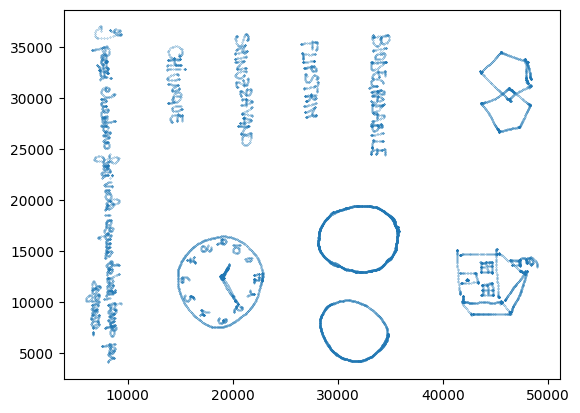

In [378]:
subject_data = labeled_data_as_timeseries.iloc[1]
plt.scatter(subject_data['x'], subject_data['y'], s=0.05 )
